In [1]:
import numpy as np
import pandas as pd
import igraph

import matplotlib
import matplotlib.cm as cm
%matplotlib inline

In [2]:
flight = pd.read_table('Airports2.csv', sep=',', header=0)

- Keep airports with at least 1000 arrival flights

In [3]:
freq = flight['Destination_airport'].value_counts()
freq_cut = freq[freq.values>=50000]
airports = freq_cut.index.tolist()
num = len(airports)
dic = {k:v for v,k in enumerate(airports)}

In [5]:
flight_cnt = flight.groupby(['Origin_airport', 'Destination_airport']).size()
matrix_cnt = np.zeros(shape=(num, num))
for (depart, arrival), row in flight_cnt.iteritems():
    if depart in dic and arrival in dic:
        matrix_cnt[dic[depart]][dic[arrival]] += row
np.fill_diagonal(matrix_cnt, 0.)
total = matrix_cnt.sum()
matrix_cnt = matrix_cnt/total

In [34]:
g = igraph.Graph.Adjacency((matrix_cnt > 0).tolist())
g.es['weight'] = matrix_cnt[matrix_cnt.nonzero()]*1000.
g.es['width'] = g.es['weight']
g.vs['label'] = airports

In [35]:
# airport importance from page rank
vec = g.pagerank(niter=100, directed=True, damping=0.85, weights='weight')

- External data for latitude and longitude of airports

In [48]:
ports = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', names=['id', 'name', 'city', 'country',
        'code', 'icao', 'lat', 'lon', 'cnt', 'count', 'altitude', 'timezone', 'dst','tz'])

latlongs = {}
for i, row in ports.iterrows():
    if row['code'] in airports:
        latlongs[row['code']] = (int(row['lon'] + 125), int(row['lat'] - 20))
        
# layout = igraph.Layout([latlongs[x] for x in airports])

#g.vs["coordinates"] = [latlongs[x] for x in airports]
#g.vs["x"] = [latlongs[x][0] for x in airports]
#g.vs["y"] = [latlongs[x][1] for x in airports]

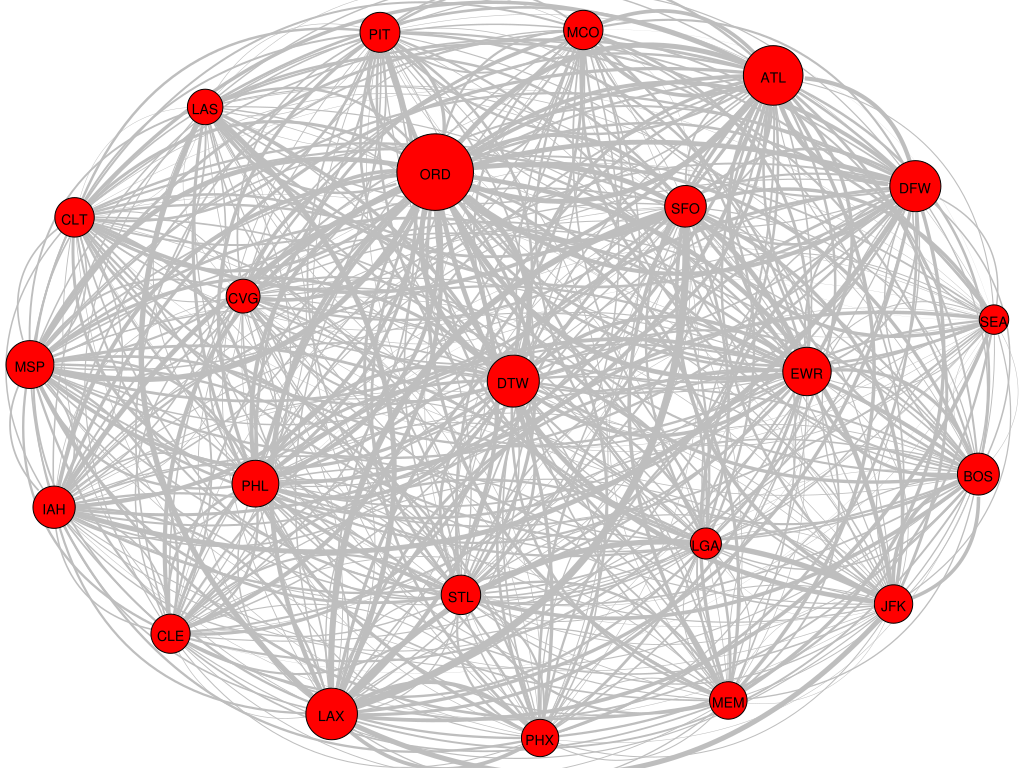

In [56]:
visual_style = {}
visual_style["layout"] = g.layout('kk')
visual_style["edge_color"] = "gray"
visual_style["vertex_size"] = 1000.*np.array(vec)
visual_style["edge_arrow_size"] = 0.05
visual_style["bbox"] = (1024, 768)
visual_style["margin"] = 30
igraph.plot(g, 'graph.png', **visual_style)